<a href="https://colab.research.google.com/github/nsprabha/neurological_disorder/blob/main/allpreexistingcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile

zip_path = "/content/drive/MyDrive/final_dataset/mri_dataset_balanced.zip"
extract_path = "/content/mri_dataset_balanced"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")


Extraction complete!


In [ ]:
import os

# Path to the balanced dataset
balanced_dataset_path = "/content/mri_dataset_balanced/content/mri_dataset_balanced"

# Count images in each class
class_counts = {}
for class_name in sorted(os.listdir(balanced_dataset_path)):
    class_dir = os.path.join(balanced_dataset_path, class_name)
    if os.path.isdir(class_dir):
        num_images = len([img for img in os.listdir(class_dir) if img.endswith(('.jpg', '.png', '.jpeg'))])
        class_counts[class_name] = num_images

# Print results
print("\n🔹 **Balanced Dataset Summary** 🔹\n")
for cls, count in class_counts.items():
    print(f"📂 {cls}: {count} images")

# Total dataset size
total_images = sum(class_counts.values())
print(f"\n📊 **Total Images in Balanced Dataset:** {total_images}")



🔹 **Balanced Dataset Summary** 🔹

📂 Brain Atrophy: 1000 images
📂 Left Retro-orbital Haemangioma: 1000 images
📂 Stroke (Haemorrhage): 865 images
📂 glioma: 1385 images
📂 healthy: 1506 images
📂 meningioma: 1398 images
📂 pituitary: 1433 images

📊 **Total Images in Balanced Dataset:** 8587


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [ ]:
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:

dataset_path = "/content/mri_dataset_balanced"
train_path = "/content/mri_dataset_train"
test_path = "/content/mri_dataset_test"


if not os.path.exists(train_path):
    os.makedirs(train_path)

if not os.path.exists(test_path):
    os.makedirs(test_path)

for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_dir):
        images = os.listdir(class_dir)
        np.random.shuffle(images)

        train_size = int(0.7 * len(images))

        train_images = images[:train_size]
        test_images = images[train_size:]

        os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_path, class_name), exist_ok=True)

        for img in train_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(train_path, class_name, img))

        for img in test_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(test_path, class_name, img))

print("Dataset successfully split into 70% train and 30% test!")


✅ Dataset successfully split into 70% train and 30% test!


In [ ]:
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset.classes)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training Complete")


Epoch [1/10], Loss: 1.5647
Epoch [2/10], Loss: 1.1266
Epoch [3/10], Loss: 1.0033
Epoch [4/10], Loss: 0.9146
Epoch [5/10], Loss: 0.8286
Epoch [6/10], Loss: 0.7629
Epoch [7/10], Loss: 0.6937
Epoch [8/10], Loss: 0.6246
Epoch [9/10], Loss: 0.5477
Epoch [10/10], Loss: 0.5097
✅ Training Complete! 🚀


In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.7770
Precision: 0.7746
Recall: 0.7770
F1-score: 0.7727


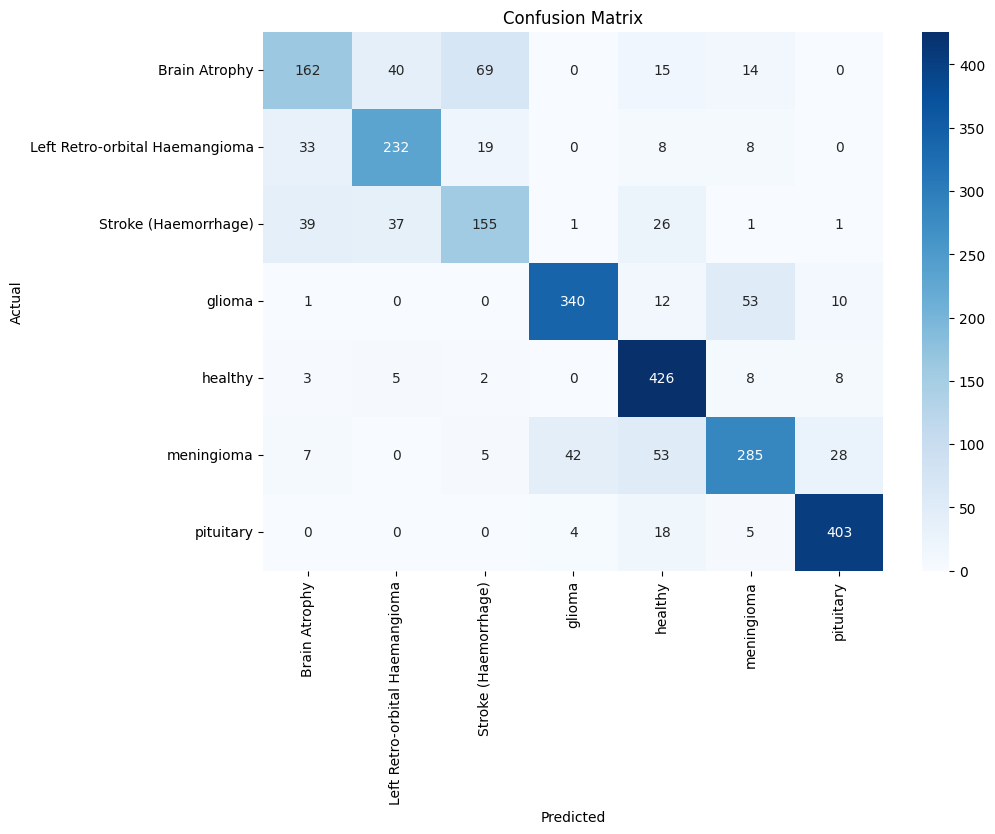

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Epoch 1/10, Loss: 1.8075
Epoch 2/10, Loss: 1.1233
Epoch 3/10, Loss: 0.8649
Epoch 4/10, Loss: 0.7648
Epoch 5/10, Loss: 0.6890
Epoch 6/10, Loss: 0.6311
Epoch 7/10, Loss: 0.5987
Epoch 8/10, Loss: 0.5494
Epoch 9/10, Loss: 0.4943
Epoch 10/10, Loss: 0.4929
Accuracy: 0.8071
Precision: 0.8003
Recall: 0.7848
F1-score: 0.7753


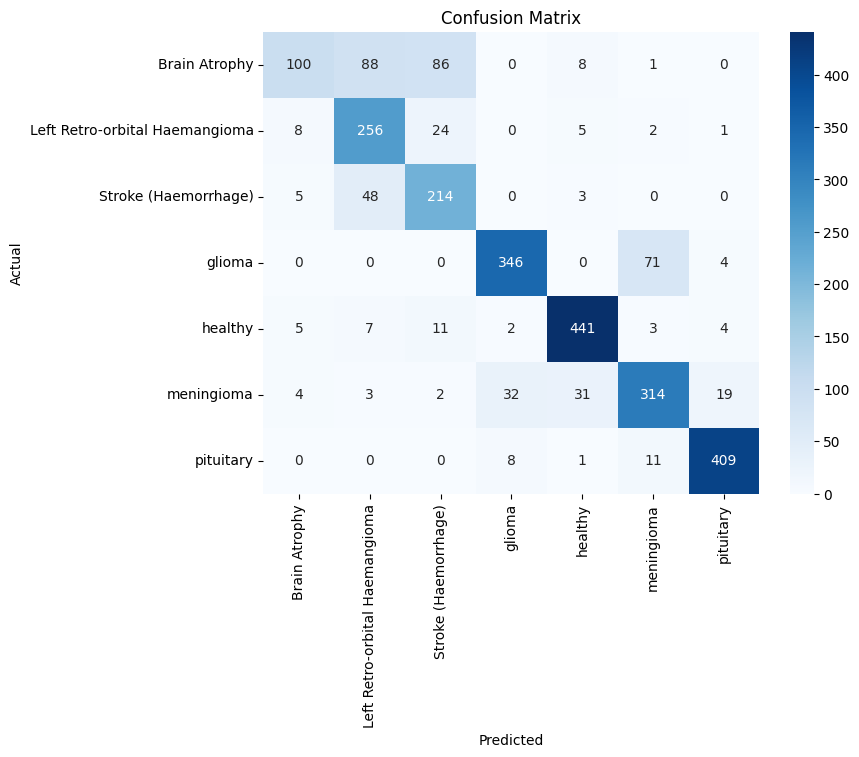

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# AlexNet model
class AlexNet(nn.Module):
    def __init__(self, num_classes=7):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root="/content/mri_dataset_balanced/content/mri_dataset_balanced", transform=data_transforms)


train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


model = AlexNet(num_classes=7).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')


model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Epoch 1/10, Loss: 1.8804
Epoch 2/10, Loss: 1.4185
Epoch 3/10, Loss: 1.0398
Epoch 4/10, Loss: 0.7375
Epoch 5/10, Loss: 0.5782
Epoch 6/10, Loss: 0.4507
Epoch 7/10, Loss: 0.3485
Epoch 8/10, Loss: 0.2520
Epoch 9/10, Loss: 0.2009
Epoch 10/10, Loss: 0.1477
Classification Report:
                                precision    recall  f1-score   support

                 Brain Atrophy       0.86      0.71      0.78       302
Left Retro-orbital Haemangioma       0.87      0.91      0.89       306
          Stroke (Haemorrhage)       0.73      0.88      0.80       244
                        glioma       0.91      0.93      0.92       446
                       healthy       0.96      0.94      0.95       445
                    meningioma       0.89      0.85      0.87       405
                     pituitary       0.96      0.99      0.98       429

                      accuracy                           0.90      2577
                     macro avg       0.89      0.89      0.88      2577
    

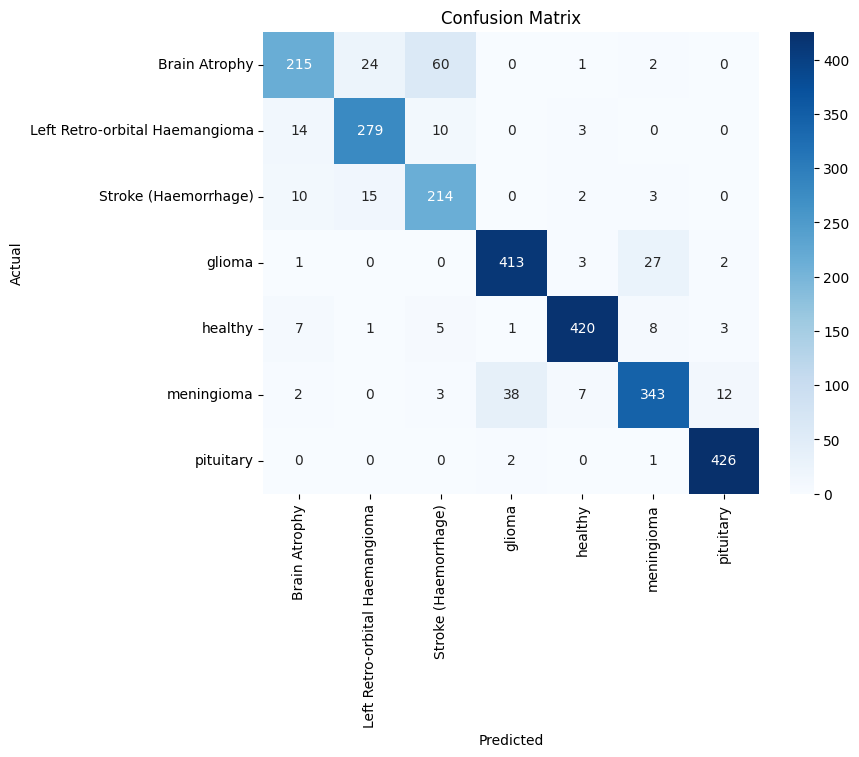

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Define VGG16 Model
class VGG16(nn.Module):
    def __init__(self, num_classes=7):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root='/content/mri_dataset_balanced/content/mri_dataset_balanced', transform=data_transform)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16(num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.classes))


conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Epoch 1/10, Loss: 1.0680, Accuracy: 0.5725
Epoch 2/10, Loss: 0.7820, Accuracy: 0.6834
Epoch 3/10, Loss: 0.6689, Accuracy: 0.7364
Epoch 4/10, Loss: 0.5586, Accuracy: 0.7725
Epoch 5/10, Loss: 0.4257, Accuracy: 0.8374
Epoch 6/10, Loss: 0.3597, Accuracy: 0.8609
Epoch 7/10, Loss: 0.2860, Accuracy: 0.8907
Epoch 8/10, Loss: 0.2185, Accuracy: 0.9221
Epoch 9/10, Loss: 0.1612, Accuracy: 0.9469
Epoch 10/10, Loss: 0.1481, Accuracy: 0.9461

Classification Report:
                                 precision    recall  f1-score   support

                 Brain Atrophy       0.47      0.99      0.64       294
Left Retro-orbital Haemangioma       0.97      0.43      0.60       318
          Stroke (Haemorrhage)       0.93      0.43      0.58       247
                        glioma       0.69      1.00      0.82       430
                       healthy       0.95      0.97      0.96       442
                    meningioma       0.99      0.45      0.62       437
                     pituitary       0.

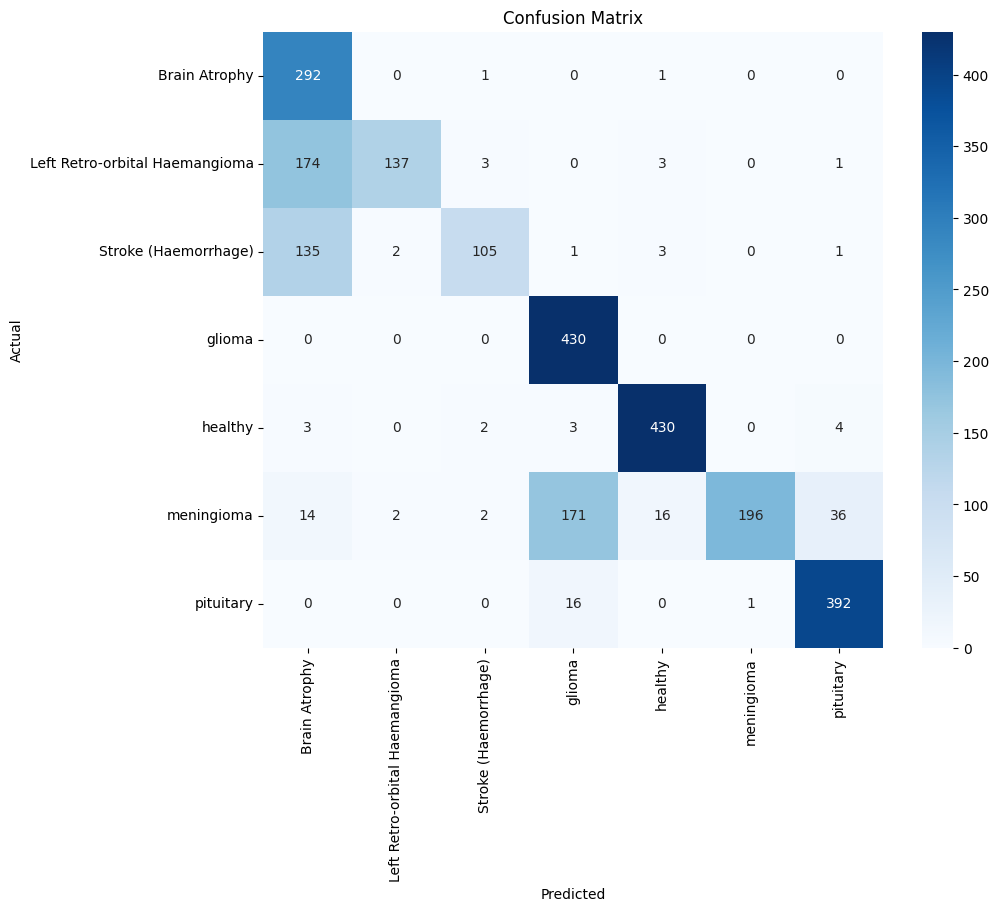

In [ ]:
#Resnet 18
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


dataset_path = "/content/mri_dataset_balanced/content/mri_dataset_balanced"
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)


train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class ResNet18Custom(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18Custom, self).__init__()
        self.model = models.resnet18(weights=None)  # No pretraining
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

num_classes = len(dataset.classes)
model = ResNet18Custom(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_acc:.4f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Classification Report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=dataset.classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Epoch [1/10], Loss: 304.4664, Train Accuracy: 32.20%
Epoch [2/10], Loss: 194.2974, Train Accuracy: 56.57%
Epoch [3/10], Loss: 151.7474, Train Accuracy: 66.16%
Epoch [4/10], Loss: 126.5720, Train Accuracy: 71.58%
Epoch [5/10], Loss: 113.5483, Train Accuracy: 75.06%
Epoch [6/10], Loss: 94.8197, Train Accuracy: 79.48%
Epoch [7/10], Loss: 88.4634, Train Accuracy: 81.68%
Epoch [8/10], Loss: 83.1488, Train Accuracy: 82.10%
Epoch [9/10], Loss: 68.4307, Train Accuracy: 86.12%
Epoch [10/10], Loss: 64.2286, Train Accuracy: 86.77%
Classification Report:
                                precision    recall  f1-score   support

                 Brain Atrophy       0.66      0.82      0.73       309
Left Retro-orbital Haemangioma       0.89      0.73      0.80       291
          Stroke (Haemorrhage)       0.79      0.78      0.79       251
                        glioma       0.94      0.86      0.90       429
                       healthy       0.96      0.94      0.95       452
                  

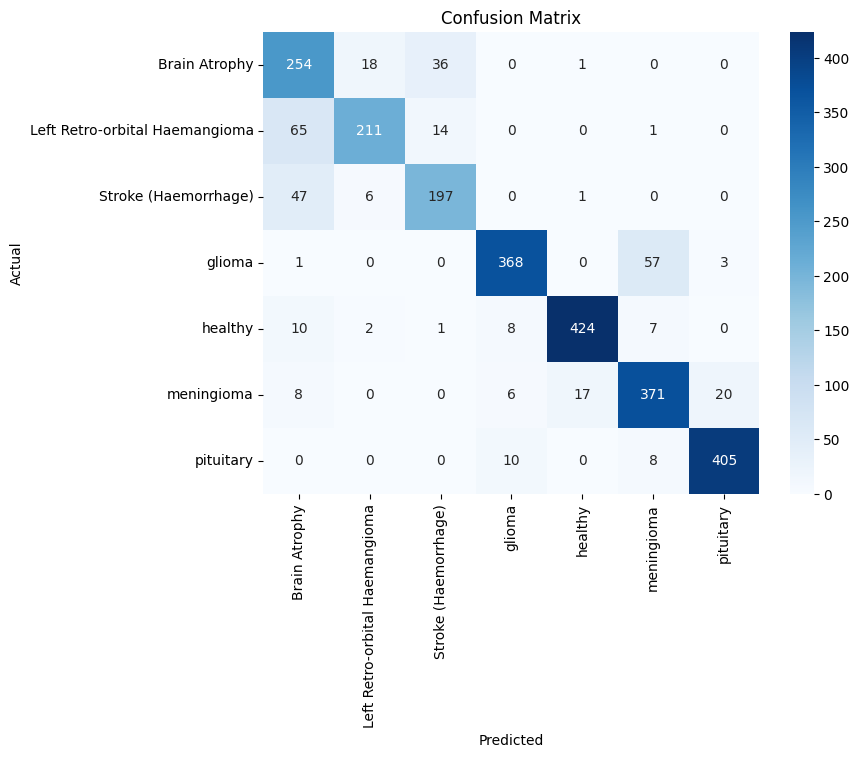

In [ ]:
#ZFNet
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import random_split

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define ZFNet Model
class ZFNet(nn.Module):
    def __init__(self, num_classes=7):
        super(ZFNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=2, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(256 * 5 * 5, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool3(self.relu(self.conv5(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# Data Preprocessing & Loading
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load full dataset
dataset_path = "/content/mri_dataset_balanced/content/mri_dataset_balanced"
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# 70-30 Split
train_size = int(0.7 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize Model, Loss Function, Optimizer
num_classes = len(full_dataset.classes)  # Auto-detect number of classes
model = ZFNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

# Evaluation
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=full_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
